In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import camelot
import pickle
from IPython.display import clear_output
import seaborn as sns

In [25]:
def extract_data():
    r = requests.get(
        "https://www.massport.com/logan-airport/about-logan/noise-abatement/complaints-by-townss/",
        headers={"user-agent": "parser/0.0.1"},
    )
    soup = BeautifulSoup(r.content, "html.parser")
    dfs = []
    base_url = "https://www.massport.com"

    total_to_process = len(soup.select("table a"))
    processed = 0

    tables = soup.find_all("table")
    for table in tables:
        year = table.find(string=re.compile(".*Noise Complaint Reports by Towns"))[0:4]
        links = table.find_all("a")
        for link in links:
            month = link.text.strip()
            link = base_url + link["href"]
            df = camelot.read_pdf(link, flavor="stream", strip_text=",")[0].df

            # delete the total row at the bottom
            df = df[~df[0].isin(["Totals:", "Communities:", "Communities", "Totals"])]

            if (df[0] == "Community").any():
                # make the first row with the word "Community" the header
                # and delete it and everything above it
                header_row_index = df[0].eq("Community").idxmax()
                df.columns = df.iloc[header_row_index].values
                df = df[header_row_index + 1:]
            else:
                print(f"Can't set head for {processed}: {link} because it doesn't have a Community column")
                print(df.head())

            df["date"] = pd.to_datetime(f"{year} {month}")
            df["link"] = link
            df.rename(columns={"Calls": "Complaints", "Callers": "Complainants"}, inplace=True)

            dfs.append(df)
            processed += 1
            clear_output(wait=True)
            print(f"[{processed * '='}{(total_to_process - processed) * ' '}]")

    # these two had parsing errors. need to look into this further
    dfs[39].columns = ["Community", "Complaints", "Addresses", "Residents", "date", "link"]
    dfs[40].columns = ["Community", "Complaints", "Residents", "date", "link"]

    # this is a yearly summary included by mistake https://www.massport.com/media/1297/2013_monthlycomplaintswebapril.pdf
    del dfs[109:113]

    return dfs

data = extract_data()
file = open("data.pkl", "wb")
pickle.dump(data, file)

[===================================================================================================================================]


In [108]:
dfs = pickle.load(open("data.pkl", "rb"))

data = pd.concat(dfs)
data["Complainants"] = pd.to_numeric(data["Complainants"])
data["Complaints"] = pd.to_numeric(data["Complaints"])
data["Addresses"] = pd.to_numeric(data["Addresses"])
data["Residents"] = pd.to_numeric(data["Residents"])
data["Households"] = pd.to_numeric(data["Households"])

# remove rows that don't have a Community name
data = data[data["Community"] != '']
# there was a parsing error somewhere
# TODO: figure out why one community is parsed as september
data = data[data["Community"] != 'September']
data = data[["Community", "Complaints", "date"]]

# some dates are missing reports from some communities
data = data.set_index(["Community", "date"])
data = data[~data.index.duplicated(keep="first")] # there's one duplicate row
new_index = pd.MultiIndex.from_product(
    data.index.levels,
    names=data.index.names,
)
# I assume missing reports means zero complaints
data = data.reindex(index=new_index, fill_value=0)

# filter out communities with very low total complaints
data = data.groupby("Community").filter(lambda x: x["Complaints"].sum() > 100)
data.to_csv("../data.csv")

[Text(0.5, 1.0, 'Airplane noise complaints in Somerville')]

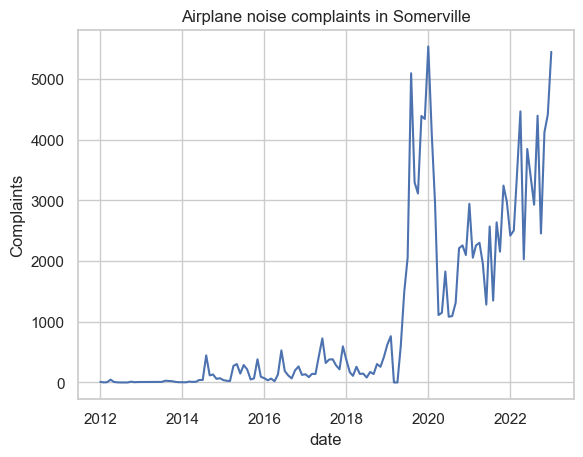

In [109]:
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=data["Complaints"]["Somerville"]
).set(title="Airplane noise complaints in Somerville")